# L15b: Combining S5 and Spike Nueral Networks
Fill me in.


### Tasks
Before we start, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Prerequisites (10 min)__: In this task, we set up the computational environment and then specify a simple text sequence, e.g., a sentence without punctuation. From this sequence, we'll build a vocabulary, an inverse vocabulary, and the training datasets for the CBOW and skip-gram models. 
* __Task 2: Build and Train a CBOW model instance (20 min)__: In this task, we build and train a Continuous Bag of Words (CBOW) model instance on a sample input sequence. We start by creating a model instance, and then we train this instance for a few epochs, and finally, we see how the model performs.
* __Task 3: Build and train a skip-gram model instance (20 min)__: In this task, we will build and train a skip-gram model instance on the sample input sequence we selected above. We start by creating a model instance, then train it for a few epochs and see how it performs.

Let's get started!

___

## Task 1: Setup, Data, Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [1]:
include("Include.jl");

In [2]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the MNIST digits data set
In this example, we'll use a Hopfield network to learn a single image pattern from [the MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database). The goal is to train the network to recognize a digit, e.g., "3" or "5", etc, and then retrieve it from a noisy input.

Load a training image dataset that we'll encode into the Hopfield network. We'll save training data in the `training_image_dataset` variable.
* _What's in the training dataset_? The `training_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`. However, the label is encoded as a `OneHotVector` (see below).
* _Hmmm. That's strange_. The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of _weird features_. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

However, before we load the training data, let's set some constants, which we use below. The comment next to each constant describes it, its permissible values, units, etc.

In [3]:
number_of_training_examples = 30; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
number_of_images_to_memorize = 3; # number of images that we want to encode

`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then we'll convert these to a vector format below.

In [4]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, number_of_rows, number_of_cols, number_of_training_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ 1:number_of_training_examples
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        training_image_dictionary[i] = image_digit_array
    end
    training_image_dictionary
end;

Next, we take the images in array format and vectorize them. 
* _What do we mean by vectorize_? Each $N\times{N}$ image array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [5]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, number_of_pixels);
            linearindex = 1;
            for row ∈ 1:number_of_rows
                for col ∈ 1:number_of_cols
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

## Task 2: What is a Spiking Neural Network?
Fill me in.

In [ ]:
number_of_samples = length(training_image_dataset); # how many samples do we have?
number_of_neurons = 2^8; # how many SSN neurons do we want?
number_of_inputs = number_of_pixels; # how many inputs do we have?
ν = 0.1; # Table 2: firing threshold https://arxiv.org/abs/2205.11276
τ = 20.0; # Table 2: time constant (ms) https://arxiv.org/abs/2205.11276
Δt = 1.0; # samping time step (ms)
T = 100; # number of time steps of length Δt (ms) to simulate

Fill me in

In [7]:
Z = let

    # initialize -
    Z = Array{Int64,2}(undef, number_of_inputs, T);

    for i ∈ 1:T
        z = training_image_dataset[i][1] |> x-> round.(Int, x);
        Z[:,i] = z;
    end
    Z 
end

784×100 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

Fill me in

In [8]:
model = let

    # build model -
    model = build(MyLIFSpikingNeuralNetworkModel, (
        Δt = Δt, # time step (ms)
        τ = τ, # time constant (ms)
        ν = ν, # firing threshold
        number_of_nodes = number_of_neurons, # number of neurons
        number_of_inputs = number_of_inputs, # number of inputs
    ));

    model;
end;

In [9]:
model.W

64×784 Matrix{Float64}:
 0.00361535   0.00972073   0.0091657    …  0.00664079   0.00710653
 0.00183639   0.00970271   0.00860735      0.00280008   0.00322316
 0.00682516   0.00312375   0.00551616      0.000494165  0.00280025
 0.001035     0.0062282    0.0074281       0.00797504   0.000775221
 0.00228541   0.00215781   0.00490865      0.00561554   0.00016104
 0.00742148   0.00621016   0.00539178   …  0.00549504   0.0039942
 0.00742953   0.0062561    0.00997749      0.00307544   0.00759337
 0.00413537   0.00563192   0.00460335      0.00225946   0.00555944
 0.0057559    0.00713928   0.00971752      0.00970587   0.00987443
 0.00962018   0.00372236   0.000408653     0.000645434  0.00446188
 ⋮                                      ⋱               
 0.00987817   0.00319892   0.00529447   …  0.00902865   0.000816405
 0.00410585   0.00582805   0.00531738      0.00799149   0.00888511
 0.00293393   0.00349514   0.00491588      0.00682093   0.00692745
 0.00303201   0.00118353   0.00846758      0.00

Fill me in

In [10]:
Z

784×100 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

In [11]:
(T,V,s) = model(Z, 100, Δ = 3);

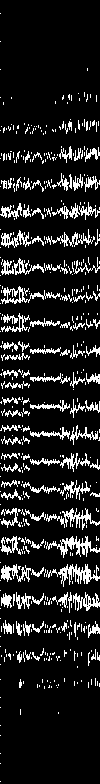

In [17]:
Gray.(Z)

Fill me in

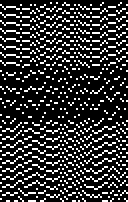

In [19]:
Gray.(s)

## Task 3: Let's build an S5 model 
Fill me in.